In [12]:
import Pkg; Pkg.add("MathOptInterface")
import Pkg; Pkg.add("FiniteDiff")

In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
using ProgressMeter
import ForwardDiff as FD
import Convex as cvx
import ECOS

include(joinpath(@__DIR__,"utils","fmincon.jl"))

  Activating environment at `~/Desktop/CMU/Term_2/16745 Optimal Control/OptimalSailboat/Project.toml`
Precompiling project...
  ✓ SnoopPrecompile
  ✓ ArrayInterfaceCore
  ✓ FiniteDiff
  3 dependencies successfully precompiled in 5 seconds (207 already precompiled)


fmincon (generic function with 1 method)

In [2]:
import Pkg
Pkg.resolve()

   Installed ArrayInterfaceCore ─ v0.1.29
   Installed SnoopPrecompile ──── v1.0.3
   Installed FiniteDiff ───────── v2.17.0
    Updating `~/Desktop/CMU/Term_2/16745 Optimal Control/OptimalSailboat/Project.toml`
  [6a86dc24] + FiniteDiff v2.17.0
    Updating `~/Desktop/CMU/Term_2/16745 Optimal Control/OptimalSailboat/Manifest.toml`
  [30b0a656] + ArrayInterfaceCore v0.1.29
  [6a86dc24] + FiniteDiff v2.17.0
  [efcf1570] + Setfield v1.1.1
  [66db9d55] + SnoopPrecompile v1.0.3
  [9fa8497b] + Future


In [5]:
"""
Converts from cartesian (x,y) to polar (r,θ) coordinates.
"""
function car2pol(x, y)
    r = √(x^2 + y^2)
    θ = atan(y, x)
    return r, θ
end;

"""
Wraps an angle (in radians) to the range [-π, π].
"""
function wrap2pi(θ)
    return θ - 2*π*floor((θ+π)/(2*π))
end;

"""
Converts from a vector of vectors to a matrix.
"""
function vec2mat(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end;

"""
Converts from a matrix to a vector of vectors.
"""
function mat2vec(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end;

### Variable Definitions

Assumptions
Small Angle of Attack (Sub 15degrees)
Linearized lift

### State Variables:

- x: Position in the longitudinal (forward-backward) direction.
- y: Position in the lateral (side-to-side) direction.
- $\psi$: Roll angle
- $\phi$: Yaw angle

- u: Linear velocity in the longitudinal (forward-backward) direction.
- $\nu$: Linear Velocity in the lateral (side-to-side) direction.
- p: angular velocity roll
- r: angular velocity yaw


#### Control Variables:
- $\lambda$ - sail angle
 - $\sigma$ - rudder angle
 

#### Wind and Force Variables:
 - $a_{tw}$ - true wind speed
 - $\psi_{tw}$ - true wind direction
 - $g_s$ - force from sail
 - $g_r$ - force from rudder

#### Parameters:
- $m$ - Mass of the sailboat
- $I_{xx}$ - Moment of inertia about the x-axis
- $I_{zz}$ - Moment of inertia about the z-axis
- $I_{xz}$ - Product of inertia
- $X_{\dot{u}}$ - Added mass in $x'$ due to acceleration in the $x'$ direction
- $Y_{\dot{\nu}}$ - Added mass in sway due to acceleration in the $y'$ direction
- $Y_{\dot{p}}$ - Added mass effect due to angular acceleration around the $x'$ axis
- $Y_{\dot{r}}$ - Cross-coupling added mass effect due to yaw rate around the $z'$ axis
- $K_{\dot{r}}$ - Added mass effect due to yaw rate affecting roll dynamics around the $z'$ axis
- $K_{\dot{p}}$ - Added mass effect due to roll rate around the $x'$ axis
- $N_{\dot{r}}$ - Added mass in yaw due to angular acceleration around the $z'$ axis




 

In [6]:
params = (
        m = 1600, # kg, boat mass
        ρw = 1020, # kg/m3, water density
        ρa = 1.23, # kg/m3, air density
        g = 9.81, # m/s2, gravity
        GMₜ = 2.4, # m, metacentric height
        Ixx = 6.8e3, # kg m2, moment of inertia
        Izz = 8.5e3, # kg m2,   moment of inertia
        Ixz = -13.4, # kg m2, moment of inertia
        Kₚ = -1.0e3, # kg m2, 
        ∇ = 1600/1020, # m3
        As = 23.8,  # m^2, sail area
        Ak = 0.93,  # m^2, keel area
        Ar = 0.30,  # m^2, rudder area
        Kp = 3e5, 
        Kd = 1e6, 
        l1 = -1.82,  # m, distance from the center of mass to the sail
        l2 = 1.35,  # m, distance from the center of mass to the rudder
        l3 = -0.66, # m
        h1 = 5.2,  # m,
        h2 = 0.95,  # m,
        h3 = 0.7,  # m,
        X_u̇ = -1.62e2, 
        Y_v̇ = -1.2e3,
        Y_ṗ = 0,  
        Y_ṙ = -3.5e2,   
        K_ṙ = 0,      
        K_ṗ = -1.0e3, 
        N_ṙ = -2.4e3,
        dl11 = 10,
        dl22 = 16,
        dl44 = 40
        )

(m = 1600, ρw = 1020, ρa = 1.23, g = 9.81, GMₜ = 2.4, Ixx = 6800.0, Izz = 8500.0, Ixz = -13.4, Kₚ = -1000.0, ∇ = 1.5686274509803921, As = 23.8, Ak = 0.93, Ar = 0.3, Kp = 300000.0, Kd = 1.0e6, l1 = -1.82, l2 = 1.35, l3 = -0.66, h1 = 5.2, h2 = 0.95, h3 = 0.7, X_u̇ = -162.0, Y_v̇ = -1200.0, Y_ṗ = 0, Y_ṙ = -350.0, K_ṙ = 0, K_ṗ = -1000.0, N_ṙ = -2400.0, dl11 = 10, dl22 = 16, dl44 = 40)

In [21]:
function J(ϕ,ψ)
    # Transformation matrix from body to inertial frame
    J = [cos(ψ) -sin(ψ)*cos(ϕ)  0 0;
         sin(ψ) cos(ψ)*cos(ϕ)  0 0;
         0 0 1 0;
         0 0 0 cos(ϕ)]
    return J
end

function J2D(ϕ,ψ)
    # Transformation matrix only for first two states
    J = [cos(ψ) -sin(ψ)*cos(ϕ);
         sin(ψ) cos(ψ)*cos(ϕ)]
    return J
end

function MRB(params)
    m, Ixx, Izz, Ixz = params.m, params.Ixx, params.Izz, params.Ixz
    # rigid body mass matrix
    M = [ m 0 0 0;
          0 m 0 0;
          0 0 Ixx -Ixz;
          0 0 -Ixz Izz]
    return M
end

function MA(params)
    X_u̇, Y_v̇, K_ṗ, N_ṙ, Y_ṗ, Y_ṙ, K_ṙ = params.X_u̇, params.Y_v̇, params.K_ṗ, params.N_ṙ, params.Y_ṗ, params.Y_ṙ, params.K_ṙ
    MA = [X_u̇ 0      0      0;
    0      Y_v̇ Yp_dot Y_ṙ;
    0      Y_ṗ K_ṗ YK_ṙ;
    0      Y_ṙ K_ṙ N_ṙ]
    return MA
end

function CRB(params, ν)
    """
    Coriolis and centripetal matrix
    x is the state in global coordinates
    """
    m = params.m
    r = ν[4]    

    C = [0 -m*r 0 0;
         m*r 0 0 0;
         0 0 0 0;
         0 0 0 0]
    return C
end

function vr(ν, η, Vc)
    """
    Calculates the norm of the velocity vector
    """
    u = ν[1]
    v = ν[2]

    psi = η[3]
    phi = η[4]

    J2D =  J2D(psi, phi)

    ur = [u; v] - J2D' * Vc
    νr = [ur; ν[3]; ν[4]]
    return νr
end

function CA(params, v)
    m = params.m
    X_u̇, Y_v̇ = params.X_u̇, params.Y_v̇
    V = z
    
    C = [ 0 0 0 Y_v̇*v;
        0 0 0 -X_u̇*v;
        0 0 0 0;
        -Y_v̇*v X_u̇*v 0 0]
    return C
end

function Dl(params)
    """
    Linear damping matrix
    """
    dl11, dl22, dl44 = params.dl11, params.dl22, params.dl44
    Dl = [dl11 0 0 0;
          0 dl22 0 0;
          0 0 0 0;
          0 0 0 dl44]
    return Dl
end

function g(params, x)
    """
    restoration forces
    """
    ρw, g_, ∇, GMₜ = params.ρw, params.g, params.∇, params.GMₜ
    # g_ is for gravity
    psi = x[3]
    g = [0;
         0; 
         ρw * g_ * ∇ *GM *  sin(psi) * cos(psi); 
         0]

    return g
end

g (generic function with 1 method)

In [8]:
function sail_angle_of_attack(λ, βws)
    """
    Angle of attack of the sail
    λ is the apparent angle of the sail
    βws is the angle of the wind
    """
    α = βws - λ + π
    return α
end

function keel_angle_of_attack(params, ν, Vc)
    """
    Angle of attack of the sail
    βws is the angle of the current
    """
    r = ν[4] # yaw velocity
    p = ν[3] # roll velocity
    h2, l3 = params.h2, params.l3
    
    νr = vr(ν, η, Vc)
    ur = νr[1]
    vr = νr[2]

    Vck = -[ur; vr] - [0; -r*l3 - p*h2] # velocity of the keel in the body frame

    βck = atan2(Vck[2], Vck[1])

    α = -βck + π
    return α
end

function rudder_angle_of_attack()

function CL(α)
    """
    Lift coefficient CL as a function of angle of attack α in radians
    """
    α_d = rad2deg(α) 
    if α_d <= 10
        return 0.0
    elseif α_d <= 25
        # Linearly increase CL from 0 at 10 degrees to 1.5 at 25 degrees
        return (α_d - 10) * (1.5 / (25 - 10)) * 10
    else
        # Linearly decrease CL from 1.5 at 25 degrees to 0.2 at 100 degrees
        return max(1.5 - (α_d - 25) * ((1.5 - 0.2) / (100 - 25)), 0.2) * 10
    end
end

function CD(α)
    """
    Drag coefficient CD as a function of angle of attack α in radians
    """
    α_d = rad2deg(α)  
    # Quadratic increase to reach 1.6 at 100 degrees
    return min((α_d^2) * (1.6 / 100^2), 1.7) * 10
end

function Sail_forces(params, Vws,λ, βws)
    As, ρa = params.As, params.ρa
    # Parameters
    l1 = params.l1
    l2 = params.l2
    h1 = params.h1

    # Calculate the forces on the sail
    SL = 0.5 * ρa * Vws^2 * As * CL(angle_of_attack(λ, βws))
    SD = 0.5 * ρa * Vws^2 * As * CD(angle_of_attack(λ, βws))

    S1 = -SL * sin(βws) + SD * cos(βws)
    S2 = SL * cos(βws) + SD * sin(βws)
    S3 = h1*S2
    S4 = S1*(l2 * sin(λ))- S2*(l1 + l2 * cos(λ))

    S = [S1, S2, S3, S4]'
    return S
end

function keel_forces(params, Vws, λ, βck)
    Ak, ρw = params.Ak, params.ρw
    h2, l3 = params.h2, params.l3
    KL = 0.5 * ρw * Vws^2 * Ak * CL(angle_of_attack(λ, βck))
    KD = 0.5 * ρw * Vws^2 * Ak * CD(angle_of_attack(λ, βck))

    K1 = KL * sin(βck) + KD * cos(βck)
    K2 = -KL * cos(βck) + KD * sin(βck)
    K3 = h2 * -K2
    K4 = l3 * K3

    K = [K1, K2, K3, K4]'
    return K
end

function rudder_forces(params, Vws, σ, βcr)
    Ar, ρw = params.Ar, params.ρw
    h3, l4 = params.h3, params.l4
    RL = 0.5 * ρw * Vws^2 * Ar * CL(angle_of_attack(σ, βck))
    RD = 0.5 * ρw * Vws^2 * Ar * CD(angle_of_attack(σ, βck))

    R1 = RL * sin(βcr) + RD * cos(βcr)
    R2 = -RL * cos(βcr) + RD * sin(βcr)
    R3 = h3 * -R2
    R4 = l4 * R3

    R = [R1, R2, R3, R4]'
    return K
end

# Function to calculate S'_{x,r}
function S_prime_x_r(params, Vws,λ, βws)
    S = Sail_forces(params, Vws,λ, βws)
    # Here S[1] represents S1, the force in the surge direction
    S_prime_x_r = S[1] / Vws^2
    return S_prime_x_r
end


S_prime_x_r (generic function with 1 method)

In [17]:
function dynamics(params, ν, η, u, Vws, βws, βck, βcr, Vc)
    λ, σ = u[1], u[2]
    S = Sail_forces(params, Vws,λ, βws)
    K = keel_forces(params, Vws, λ, βck)
    R = rudder_forces(params, Vws, σ, βcr)

    Mrb = MRB(params)
    Ma = MA(params)
    Crb = CRB(params, ν)
    Ca = CA(params, ν)
    Dl = Dl(params)
    g = g(params, η)

    # Non-linear dynamics
    vr = vr(ν, η, Vc)
    v_dot = (S + K + R - (Crb * v + Ca * vr + Dl + g)) * inv(Mrb + Ma)
    return v_dot
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual
    ẋ2 = dynamics(params, x2, u)
    ẋ1 = dynamics(params, x1, u)
    x_half = 0.5 * (x1 + x2) + dt / 8 * (ẋ1-ẋ2)
    ẋ_half = dynamics(params, x_half, u)
    return x1 + dt/6 * (ẋ1 + 4* ẋ_half + ẋ2) - x2
end

function rk4(params::NamedTuple, η::Vector, u,dt::Float64)
    # vanilla RK4
    J = J(η[4], η[3])
    ν = J * η
    k1 = dt*dynamics(params, ν, η, u)
    ν = J * (η + k1/2)
    k2 = dt*dynamics(params, ν, η + k1/2, u)
    ν = J * (η + k2/2)
    k3 = dt*dynamics(params, ν, η + k2/2, u)
    ν = J * (η + k3)
    k4 = dt*dynamics(params, ν, η + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    end

rk4 (generic function with 1 method)

# Plotting

In [12]:
function plot_boat(x, u, p)
    xₒ, yₒ, θ, v, θ̇ = x
    δᵣ, δₛ = u

    k₁ = 0.4 # boat width scale factor
    k₂ = 0.3 # rudder scale factor
    k₃ = 1.5 # sail scale factor

    points = [xₒ + (p[6]+p[7])*cos(θ)           yₒ + (p[6]+p[7])*sin(θ);
              xₒ + k₁*p[7]*sin(θ) + p[6]*cos(θ) yₒ - k₁*p[7]*cos(θ) + p[6]*sin(θ);
              xₒ + k₁*p[7]*sin(θ) - p[7]*cos(θ) yₒ - k₁*p[7]*cos(θ) - p[7]*sin(θ);
              xₒ - k₁*p[7]*sin(θ) - p[7]*cos(θ) yₒ + k₁*p[7]*cos(θ) - p[7]*sin(θ);
              xₒ - k₁*p[7]*sin(θ) + p[6]*cos(θ) yₒ + k₁*p[7]*cos(θ) + p[6]*sin(θ);
              xₒ + (p[6]+p[7])*cos(θ)           yₒ + (p[6]+p[7])*sin(θ);]

    # body
    plot!(points[1:end,1], points[1:end,2],
          color=:black, fill=(0, 0.1, :black), label=false)

    # rudder
    plot!([xₒ-p[7]*cos(θ), xₒ-p[7]*cos(θ)-k₂*p[7]*cos(θ+δᵣ)],
          [yₒ-p[7]*sin(θ), yₒ-p[7]*sin(θ)-k₂*p[7]*sin(θ+δᵣ)],
          color=:blue, label=false)

    # sail
    plot!([xₒ+p[6]*cos(θ), xₒ+p[6]*cos(θ)-k₃*p[6]*cos(θ+δₛ)],
          [yₒ+p[6]*sin(θ), yₒ+p[6]*sin(θ)-k₃*p[6]*sin(θ+δₛ)],
          color=:blue, label=false)
end;
function true_wind(xₒ, yₒ)
      ẋ_tw = 1.
      ẏ_tw = 0.
      return ẋ_tw, ẏ_tw
  end;
function plot_wind(xlims, ylims)
      points = vcat([(x,y) for x=LinRange(xlims...,20), y=LinRange(ylims...,20)]...)
      vectors = [true_wind(p...) for p=points]
      quiver!(points, quiver=vectors)
end;

function plot_waypoint(x, y, label)
      scatter!([x], [y], label=label)
end

function plot_scene(x, u, p; waypoints=(), xlims=(-20,20), ylims=(-20,20))
      scene = plot(size=(800,800), xlims=xlims, ylims=ylims)
      plot_boat(x, u, p)
      plot_wind(xlims, ylims)
      for waypoint = waypoints
            plot_waypoint(waypoint...)
      end
      
      return scene
end;

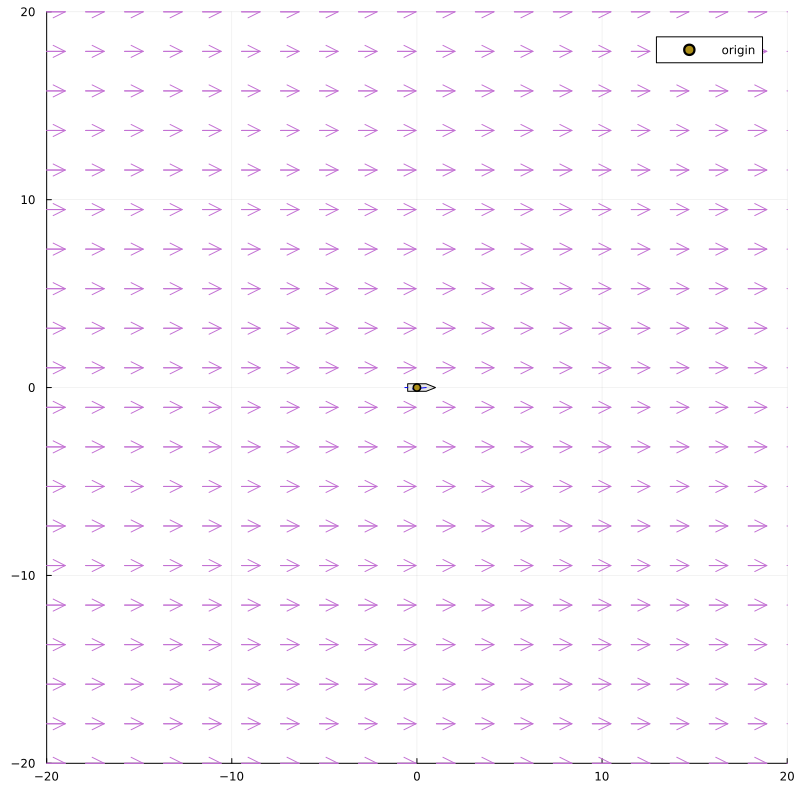

In [13]:
let
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, 0.0, 0.0, 0.0]
    u = [0.0, π/32]
    plot_scene(x, u, p, waypoints=[(0,0,"origin")])
end

In [20]:
let 
    n = 100
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, π/2, 0.0, 0.0]
    u = [0, π/16]
    Δt = 0.1
    anim = @animate for i ∈ 1:n
        plot_scene(x, u, p)
        x = rk4(params,x, u, Δt)
    end
    gif(anim, "output/test_anim.gif", fps = 15)
end

MethodError: MethodError: no method matching dynamics(::NamedTuple{(:m, :ρw, :ρa, :g, :GMₜ, :Ixx, :Izz, :Ixz, :Kₚ, :∇, :As, :Ak, :Ar, :Kp, :Kd, :l1, :l2, :l3, :h1, :h2, :h3, :X_u̇, :Y_v̇, :Y_ṗ, :Y_ṙ, :K_ṙ, :K_ṗ, :N_ṙ, :dl11, :dl22, :dl44), Tuple{Int64, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Int64, Float64, Float64, Int64, Int64, Int64}}, ::Vector{Float64}, ::Vector{Float64})
Closest candidates are:
  dynamics(::Any, ::Any, ::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at /Users/deniskaanalpay/Desktop/CMU/Term_2/16745 Optimal Control/OptimalSailboat/Low_Level_Control.ipynb:1